In [ ]:
# ✈️ Twitter US Airline Sentiment Analysis
Analyze sentiment trends from Twitter data using the Kaggle dataset.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Using the specific path you provided
df = pd.read_csv(r"C:\Users\Lenovo\Downloads\Tweets.csv")
# Note the 'r' prefix which treats the string as a raw string
# This prevents Python from interpreting backslashes as escape characters

df["tweet_created"] = pd.to_datetime(df["tweet_created"])
df["date_only"] = df["tweet_created"].dt.date
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,date_only
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52-08:00,NaN,Eastern Time (US & Canada),2015-02-24
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59-08:00,NaN,Pacific Time (US & Canada),2015-02-24
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada),2015-02-24
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36-08:00,NaN,Pacific Time (US & Canada),2015-02-24
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45-08:00,NaN,Pacific Time (US & Canada),2015-02-24


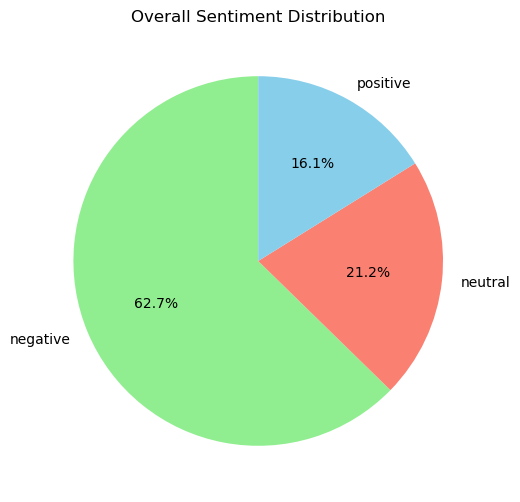

In [8]:
df['airline_sentiment'].value_counts().plot.pie(
    autopct='%1.1f%%', startangle=90,
    colors=['lightgreen', 'salmon', 'skyblue'],
    figsize=(6, 6)
)
plt.title('Overall Sentiment Distribution')
plt.ylabel('')
plt.show()


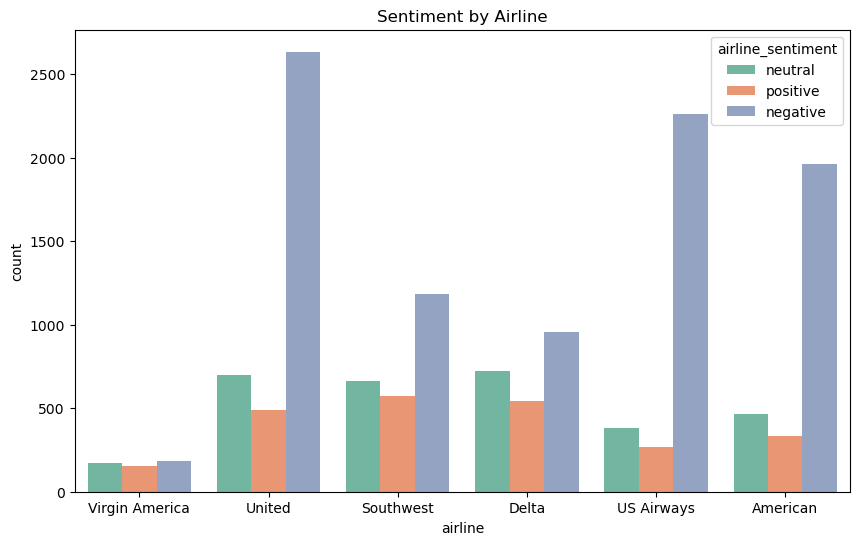

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='airline', hue='airline_sentiment', palette='Set2')
plt.title('Sentiment by Airline')
plt.show()


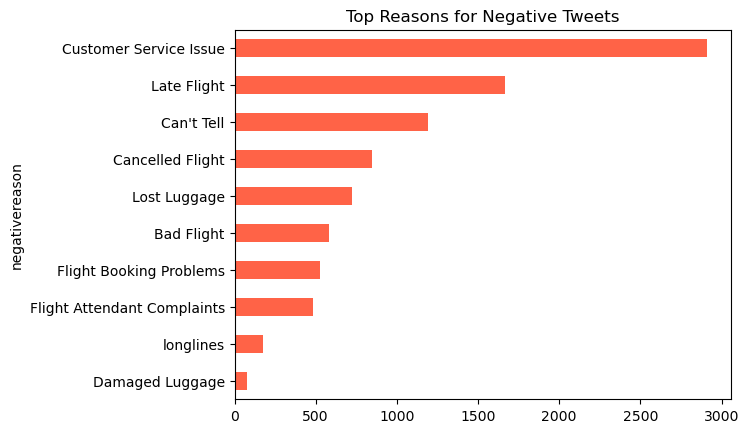

In [12]:
neg_reasons = df[df['airline_sentiment'] == 'negative']['negativereason'].value_counts().head(10)
neg_reasons.plot(kind='barh', color='tomato')
plt.title('Top Reasons for Negative Tweets')
plt.gca().invert_yaxis()
plt.show()


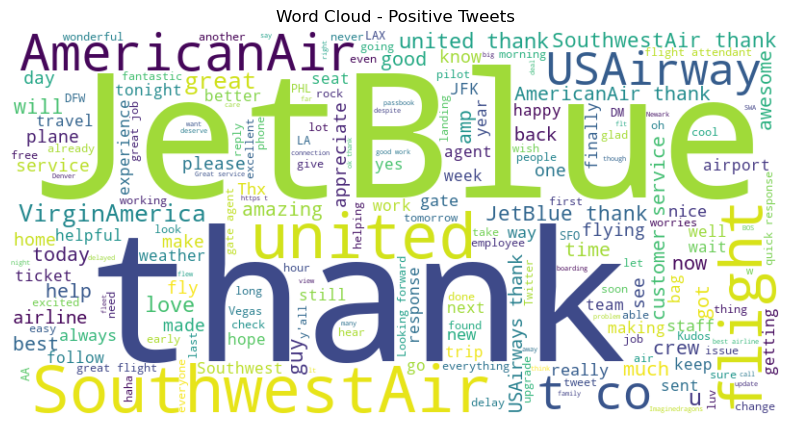

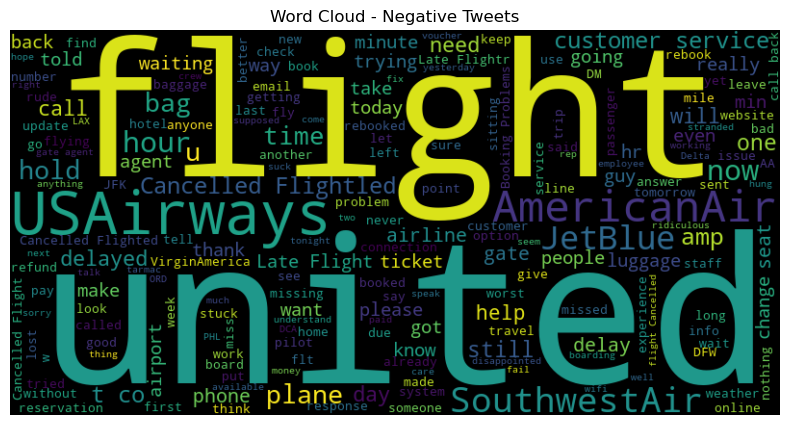

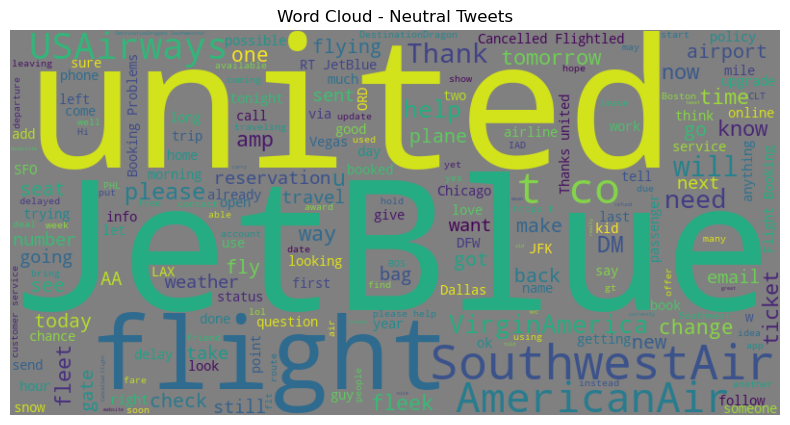

In [14]:
for sentiment, color in [('positive', 'white'), ('negative', 'black'), ('neutral', 'gray')]:
    text = " ".join(df[df["airline_sentiment"] == sentiment]["text"].dropna())
    wc = WordCloud(width=800, height=400, background_color=color).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {sentiment.capitalize()} Tweets')
    plt.show()


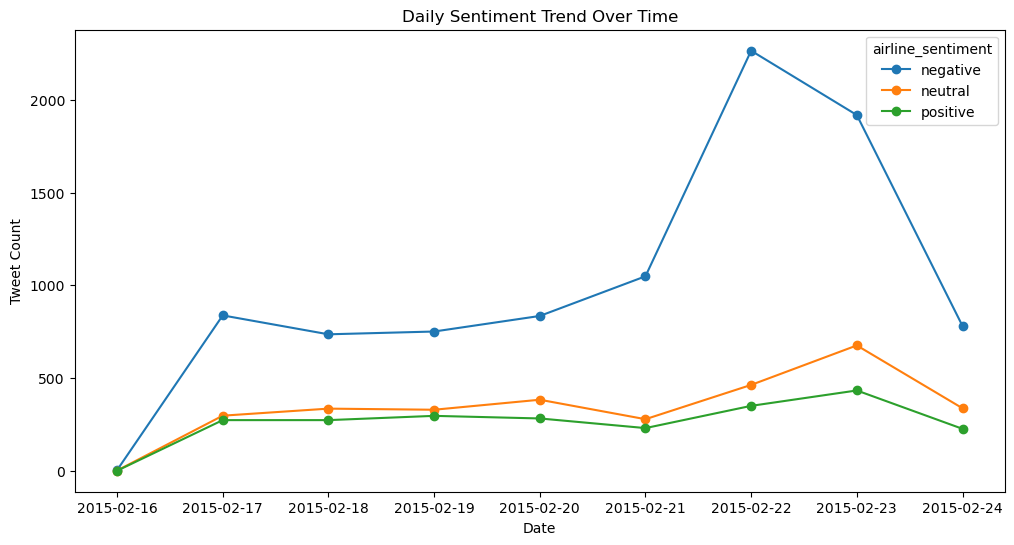

In [16]:
daily_trend = df.groupby(["date_only", "airline_sentiment"]).size().unstack().fillna(0)
daily_trend.plot(marker='o', figsize=(12, 6))
plt.title("Daily Sentiment Trend Over Time")
plt.ylabel("Tweet Count")
plt.xlabel("Date")
plt.show()


In [18]:
top_neg_by_airline = df[df["airline_sentiment"] == "negative"]
top_neg_by_airline.groupby(["airline", "negativereason"]).size().unstack().fillna(0).style.background_gradient(cmap='Reds')


negativereason,Bad Flight,Can't Tell,Cancelled Flight,Customer Service Issue,Damaged Luggage,Flight Attendant Complaints,Flight Booking Problems,Late Flight,Lost Luggage,longlines
airline,,,,,,,,,,
American,87,198,246,768,12,87,130,249,149,34
Delta,64,186,51,199,11,60,44,269,57,14
Southwest,90,159,162,391,14,38,61,152,90,29
US Airways,104,246,189,811,11,123,122,453,154,50
United,216,379,181,681,22,168,144,525,269,48
Virgin America,19,22,18,60,4,5,28,17,5,3


In [20]:
df["hour"] = pd.to_datetime(df["tweet_created"]).dt.hour
df["weekday"] = pd.to_datetime(df["tweet_created"]).dt.day_name()


In [22]:
from sklearn.feature_extraction.text import CountVectorizer

positive_texts = df[df["airline_sentiment"]=="positive"]["text"]
vectorizer = CountVectorizer(ngram_range=(1,2), stop_words="english").fit(positive_texts)
X = vectorizer.transform(positive_texts)
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
sorted(words_freq, key = lambda x: x[1], reverse=True)[:10]


[('thanks', 611),
 ('jetblue', 595),
 ('southwestair', 576),
 ('united', 528),
 ('thank', 455),
 ('flight', 381),
 ('americanair', 355),
 ('usairways', 276),
 ('great', 236),
 ('http', 217)]

In [24]:
# 🔍 Topic Modeling on Negative Tweets using LDA
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora
import gensim
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Filter for negative tweets only
neg_texts = df[df['airline_sentiment'] == 'negative']['text']

# Preprocess
def preprocess(text):
    tokens = gensim.utils.simple_preprocess(text, deacc=True)
    return [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 3]

processed_docs = neg_texts.apply(preprocess)

# Create dictionary and corpus
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Train LDA model
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,
    random_state=42,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# Print topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...


Topic 0: 0.037*"southwestair" + 0.010*"http" + 0.008*"need" + 0.008*"check" + 0.007*"stop" + 0.006*"weather" + 0.006*"excuse" + 0.005*"close" + 0.005*"boarded" + 0.005*"bag"
Topic 1: 0.047*"americanair" + 0.029*"jetblue" + 0.028*"united" + 0.019*"flight" + 0.015*"time" + 0.011*"would" + 0.010*"customer" + 0.010*"seat" + 0.008*"service" + 0.007*"like"
Topic 2: 0.067*"flight" + 0.035*"usairways" + 0.030*"plane" + 0.030*"hour" + 0.028*"americanair" + 0.027*"united" + 0.024*"delayed" + 0.023*"gate" + 0.014*"late" + 0.014*"waiting"
Topic 3: 0.084*"usairways" + 0.052*"americanair" + 0.026*"hour" + 0.025*"service" + 0.024*"hold" + 0.021*"customer" + 0.017*"call" + 0.015*"help" + 0.014*"phone" + 0.011*"worst"
Topic 4: 0.095*"flight" + 0.064*"cancelled" + 0.063*"americanair" + 0.032*"flightled" + 0.017*"help" + 0.016*"southwestair" + 0.014*"flighted" + 0.013*"tomorrow" + 0.012*"call" + 0.012*"change"


In [26]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
df['vader_score'] = df['text'].apply(lambda x: sid.polarity_scores(x)['compound'])


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...


In [28]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

df['vader_score'] = df['text'].apply(lambda x: sid.polarity_scores(x)['compound'])


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Text(0.5, 1.0, 'Net Sentiment Score by Airline')

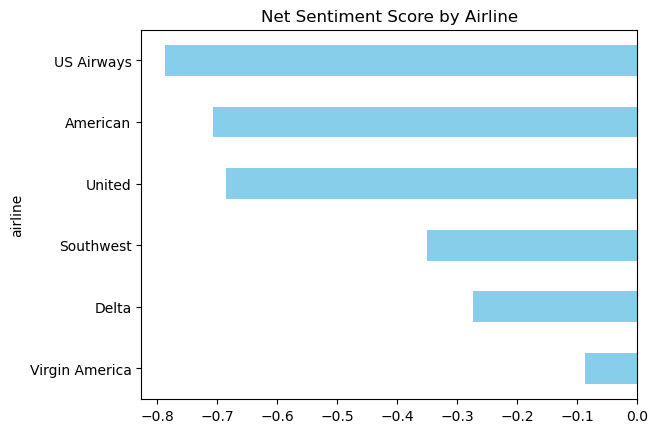

In [30]:
net_sentiment = (
    df[df['airline_sentiment'] != 'neutral']
    .assign(score=df['airline_sentiment'].map({'positive': 1, 'negative': -1}))
    .groupby('airline')['score'].mean()
    .sort_values(ascending=False)
)
net_sentiment.plot(kind='barh', color='skyblue')
plt.title("Net Sentiment Score by Airline")


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Filter only positive & negative for binary classification
df_binary = df[df['airline_sentiment'] != 'neutral']

X = df_binary['text']
y = df_binary['airline_sentiment'].map({'positive': 1, 'negative': 0})  # Convert to binary

# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X_vec = vectorizer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1862
           1       0.91      0.53      0.67       447

    accuracy                           0.90      2309
   macro avg       0.90      0.76      0.81      2309
weighted avg       0.90      0.90      0.89      2309

